# **UTS - CNN (Convolutional Neural Network) – Visual Data - Klasifikasi Ikan**

# Install Library

In [34]:
%pip install numpy pandas matplotlib scikit-learn tensorflow


# Import Library

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise, ActivityRegularization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import warnings

warnings.filterwarnings('ignore')


# Dataset

In [8]:
import os
from google.colab import drive # Import library untuk mount Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path dataset di Google Drive
dataset_path = '/content/drive/My Drive/FishImgDataset' # Ganti dengan path ke dataset Anda di Google Drive
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# ... (kode lainnya tetap sama) ...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memeriksa dataset...
File tidak valid: /content/drive/My Drive/FishImgDataset/train/Silver Perch/silver perch (1).webp
File tidak valid: /content/drive/My Drive/FishImgDataset/train/Silver Perch/silver perch (4).webp
Direktori: /content/drive/My Drive/FishImgDataset/train
Jumlah gambar valid: 8819
Jumlah gambar tidak valid: 2
Jenis ikan: ['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead', 'Silver Carp', 'Tilapia', 'Silver Barb', 'Perch', 'Indo-Pacific Tarpon', 'Knifefish', 'Mosquito Fish', 'Jaguar Gapote', 'Indian Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Mudfish', 'Mullet', 'Janitor Fish', 'Black Spotted Barb', 'Gold Fish', 'Glass Perchlet', 'Freshwater Eel', 'Catfish', 'Grass Carp', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Bangus', 'Big Head Carp']
--------------------------------------------------
Direk

<Figure size 1400x800 with 0 Axes>

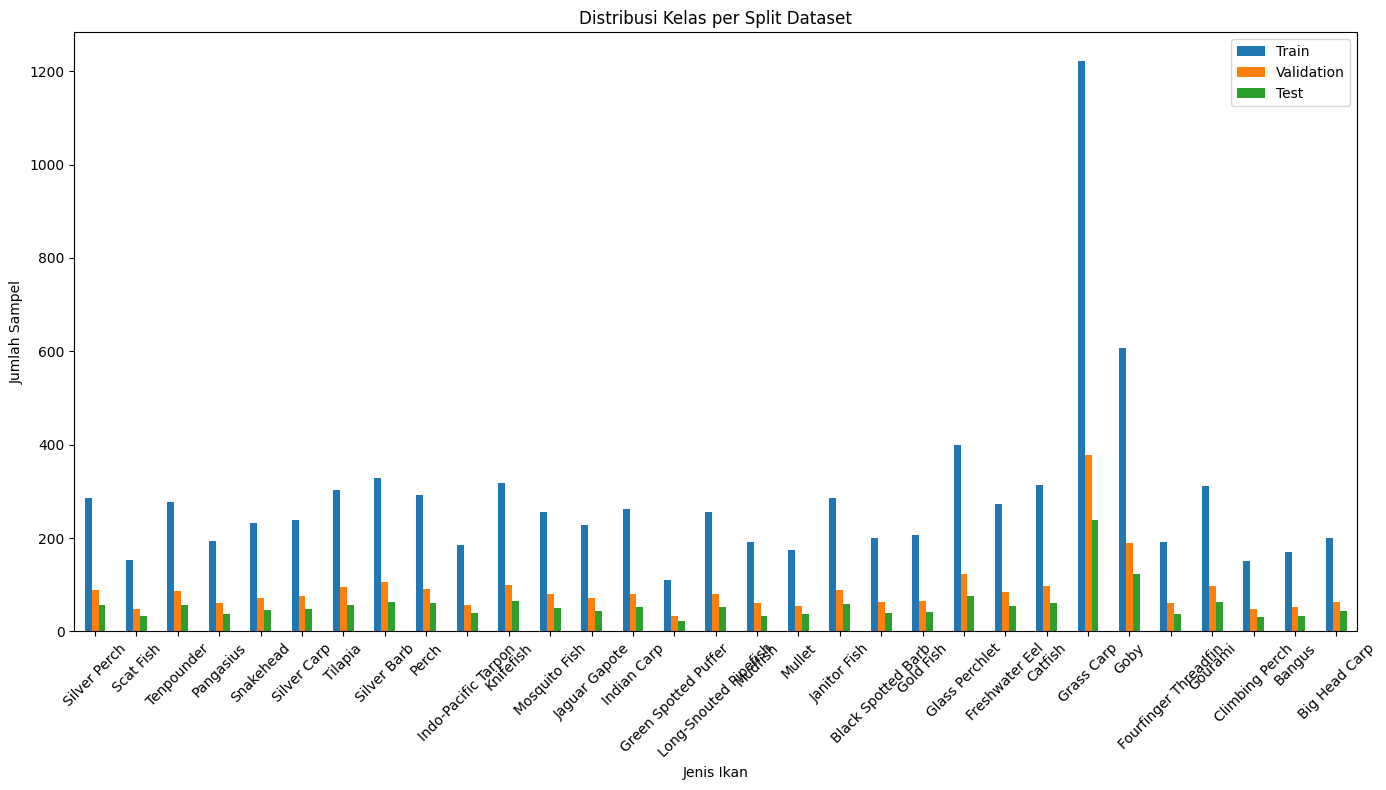

In [9]:
# Tentukan path dataset
#dataset_path = 'FishImgDataset'
#train_path = os.path.join(dataset_path, 'train')
#val_path = os.path.join(dataset_path, 'val')
#test_path = os.path.join(dataset_path, 'test')

import os
from google.colab import drive # Import library untuk mount Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path dataset di Google Drive
dataset_path = '/content/drive/My Drive/FishImgDataset' # Ganti dengan path ke dataset Anda di Google Drive
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# ... (kode lainnya tetap sama) ...

# Fungsi untuk memeriksa keberadaan dan validitas gambar
def check_image_validity(directory):
    valid_images = 0
    invalid_images = 0
    fish_types = []

    for fish_type in os.listdir(directory):
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            fish_types.append(fish_type)
            for image_file in os.listdir(fish_dir):
                image_path = os.path.join(fish_dir, image_file)
                try:
                    img = tf.io.decode_image(tf.io.read_file(image_path))
                    valid_images += 1
                except:
                    invalid_images += 1
                    print(f"File tidak valid: {image_path}")

    print(f"Direktori: {directory}")
    print(f"Jumlah gambar valid: {valid_images}")
    print(f"Jumlah gambar tidak valid: {invalid_images}")
    print(f"Jenis ikan: {fish_types}")
    print("-" * 50)

    return fish_types

# Memeriksa validitas dataset
print("Memeriksa dataset...")
train_fish_types = check_image_validity(train_path)
val_fish_types = check_image_validity(val_path)
test_fish_types = check_image_validity(test_path)

# Membuat DataFrame untuk menghitung jumlah sampel per kelas
def get_class_distribution(directory, fish_types):
    distribution = {}
    for fish_type in fish_types:
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            count = len(os.listdir(fish_dir))
            distribution[fish_type] = count
    return distribution

train_distribution = get_class_distribution(train_path, train_fish_types)
val_distribution = get_class_distribution(val_path, val_fish_types)
test_distribution = get_class_distribution(test_path, test_fish_types)

# Membuat DataFrame untuk visualisasi distribusi kelas
df_distribution = pd.DataFrame({
    'Train': train_distribution,
    'Validation': val_distribution,
    'Test': test_distribution
})

print("Distribusi kelas per split dataset:")
print(df_distribution)

# Visualisasi distribusi kelas
plt.figure(figsize=(14, 8))
df_distribution.plot(kind='bar', figsize=(14, 8))
plt.title('Distribusi Kelas per Split Dataset')
plt.xlabel('Jenis Ikan')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fish_class_distribution.png')
plt.show()


In [10]:
# Konstanta untuk preprocessing
IMG_SIZE = 84  # Ukuran standar untuk banyak arsitektur CNN
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.1],
    channel_shift_range=10,
    fill_mode='reflect'
)

# Hanya rescaling untuk validation dan test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training, validation, dan test
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Simpan informasi kelas
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Mapping kelas: {class_indices}")


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas: 31
Nama kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Mapping kelas: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 1

Visualisasi augmentasi data...


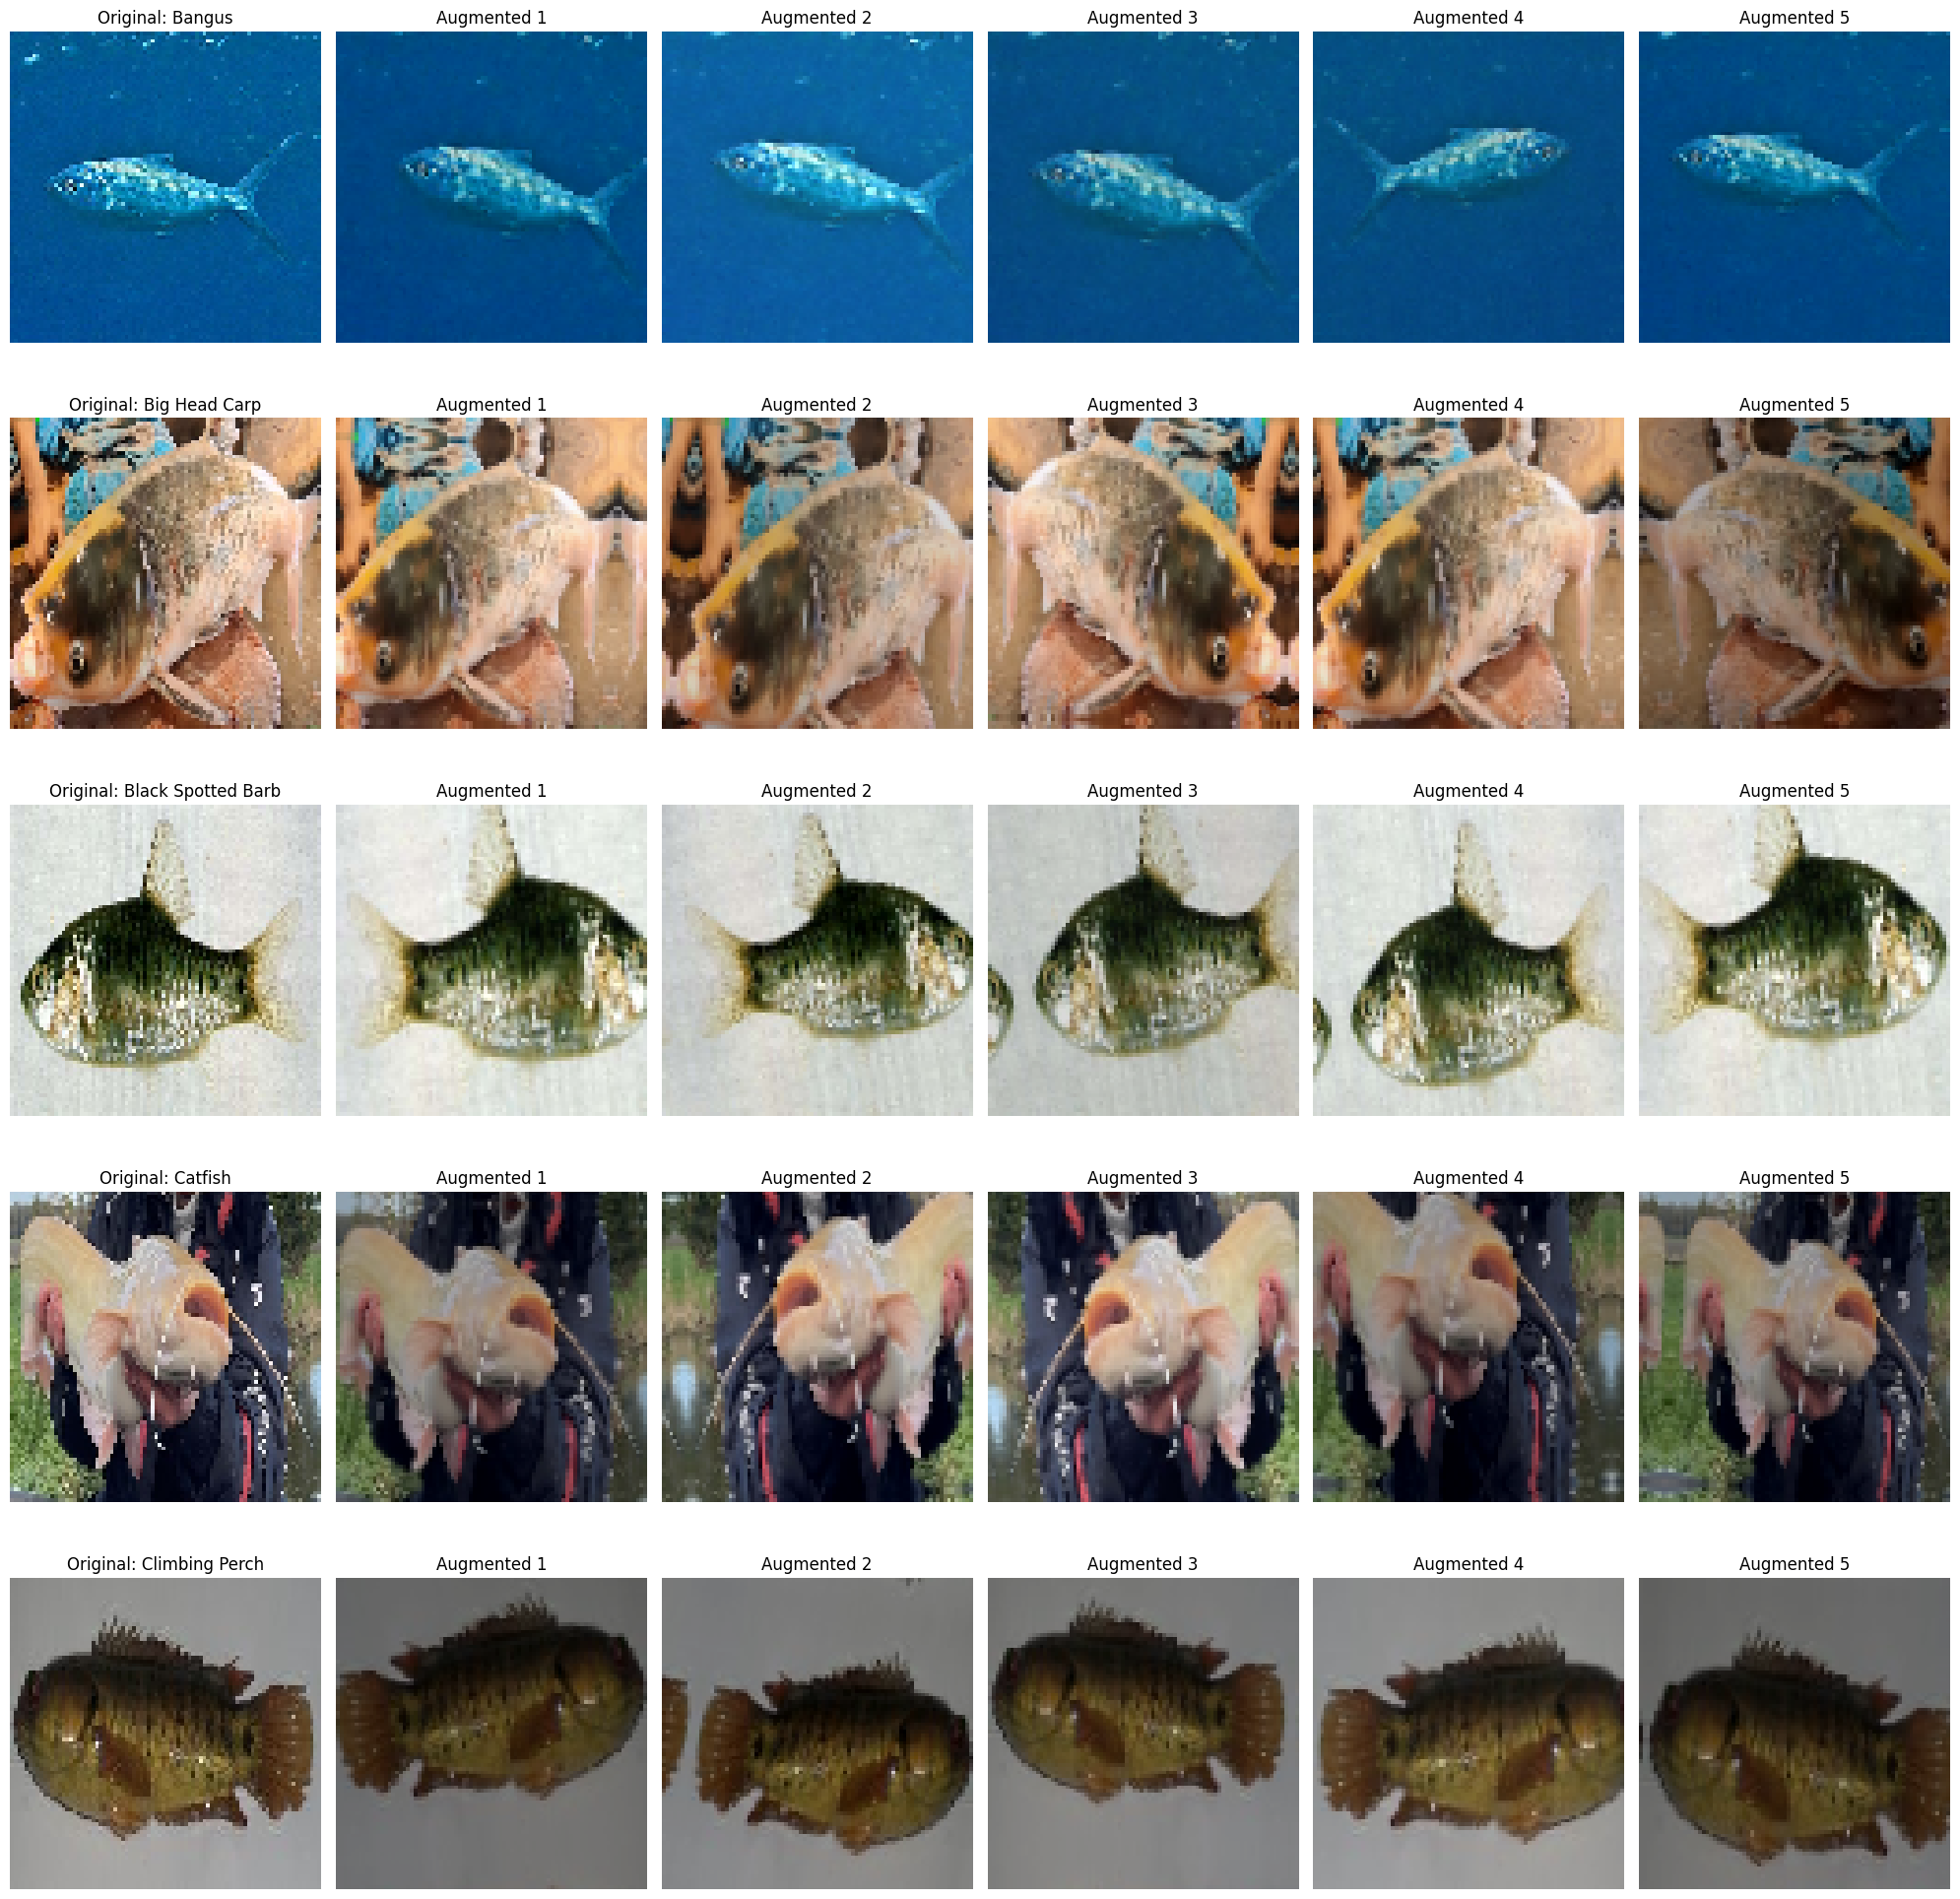

In [15]:
# Visualisasi beberapa contoh gambar dari dataset beserta augmentasi
def visualize_augmentation(datagen, dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(20, 20))
    for i, fish_type in enumerate(class_names[:min(5, len(class_names))]):
        sample_dir = os.path.join(dataset_path, fish_type)
        if os.path.isdir(sample_dir):
            sample_files = os.listdir(sample_dir)[:1]  # Ambil 1 gambar per kelas
            for j, file in enumerate(sample_files):
                img_path = os.path.join(sample_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Visualisasi gambar asli
                plt.subplot(len(class_names[:min(5, len(class_names))]),
                            num_samples + 1,
                            i * (num_samples + 1) + 1)
                plt.imshow(img)
                plt.title(f"Original: {fish_type}")
                plt.axis('off')

                # Visualisasi augmentasi
                augm_iterator = datagen.flow(x, batch_size=1)
                for k in range(num_samples):
                    augm_img = next(augm_iterator)[0]
                    plt.subplot(len(class_names[:min(5, len(class_names))]),
                                num_samples + 1,
                                i * (num_samples + 1) + k + 2)
                    plt.imshow(augm_img)
                    plt.title(f"Augmented {k+1}")
                    plt.axis('off')
                break

    plt.tight_layout()
    plt.savefig('data_augmentation_samples.png')
    plt.show()

print("Visualisasi augmentasi data...")
visualize_augmentation(train_datagen, train_path, class_names)


In [16]:
def evaluate_metrics(y_true, y_pred, y_prob, num_classes=num_classes):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }


In [17]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Fungsi untuk menampilkan ROC curve
def visualize_roc_curve(y_true, y_scores):
    # Binarize the output
    n_classes = y_scores.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for a specific class (e.g., class 1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[1], tpr[1], label=f'ROC curve (area = {roc_auc[1]:.2f})')  # Example: Plotting for class 1
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10)) # Increase figure size
    plt.matshow(cm, cmap='Blues', fignum=1)
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(num_classes), class_names, rotation=90, fontsize=8) # Rotate x-axis labels
    plt.yticks(range(num_classes), class_names, fontsize=8) # Adjust y-axis label font size
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


# Bnagun Model

In [18]:
# Membuat model CNN
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    # Inisialisasi model
    model = Sequential([
        # Input Layer
        Input(shape=input_shape),

        # Blok Konvolusional 1
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Inisialisasi model
model_cnn = create_cnn_model()


In [19]:
# Kompilasi model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#
model_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,274,655 (54.45 MB)

 Trainable params: 14,271,839 (54.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Latih Model

In [22]:
# Callbacks untuk optimasi training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_regularized_model.keras', save_best_only=True)
]

# Menghitung steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Training model
print("Melatih model CNN...")
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


Melatih model CNN...
Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1892s 7s/step - accuracy: 0.4185 - loss: 2.3588 - val_accuracy: 0.4602 - val_loss: 2.2048 - learning_rate: 0.0010
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1896s 7s/step - accuracy: 0.4585 - loss: 2.2202 - val_accuracy: 0.3148 - val_loss: 2.8064 - learning_rate: 0.0010
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1899s 7s/step - accuracy: 0.4947 - loss: 2.1023 - val_accuracy: 0.4344 - val_loss: 2.2764 - learning_rate: 0.0010
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1943s 7s/step - accuracy: 0.5356 - loss: 2.0173 - val_accuracy: 0.4831 - val_loss: 2.2818 - learning_rate: 0.0010
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1941s 7s/step - accuracy: 0.5670 - loss: 1.9095 - val_accuracy: 0.6107 - val_loss: 1.8084 - learning_rate: 0.0010
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1889s 7s/step - accuracy: 0.5975 - loss: 1.8327 - val_accuracy: 0.5820 - val_loss: 1.9510 - learning_rate: 0.0010
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1899s 7s/step -

KeyboardInterrupt: 

# Evaluasi Model

In [23]:
test_loss, test_accuracy = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_test = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_test.extend(np.argmax(y_batch, axis=1))
    y_pred_prob = model_cnn.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_pred_proba.extend(y_pred_prob)

# Mengonversi ke numpy array
y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
results = evaluate_metrics(y_test, y_pred, y_pred_proba)

# Output metrik evaluasi
print("=====Hasil evaluasi=====")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUC: {results['auc']:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7097 - loss: 1.5534
Test accuracy: 0.7278
=====Hasil evaluasi=====
Accuracy: 0.7278
Precision: 0.7728
Recall: 0.7278
F1 Score: 0.7319
AUC: 0.9816


# Visualisasi

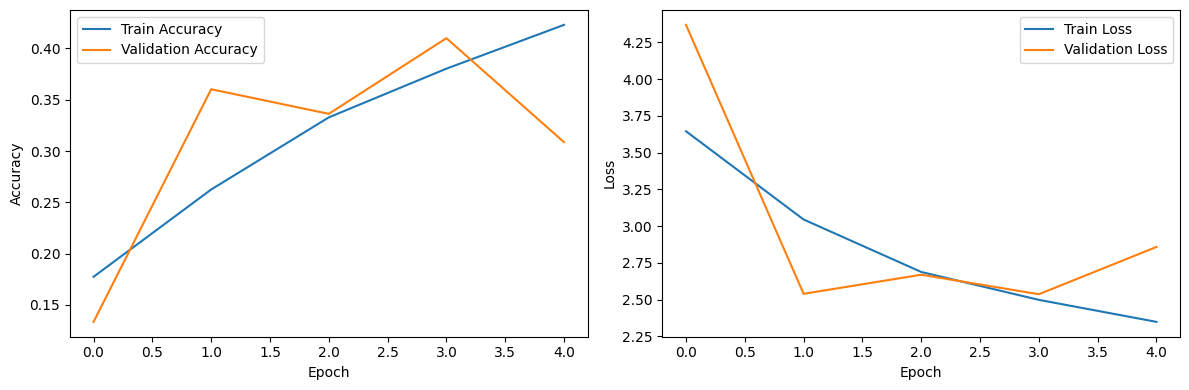

In [27]:
# Plot training history
visualize_results(history)


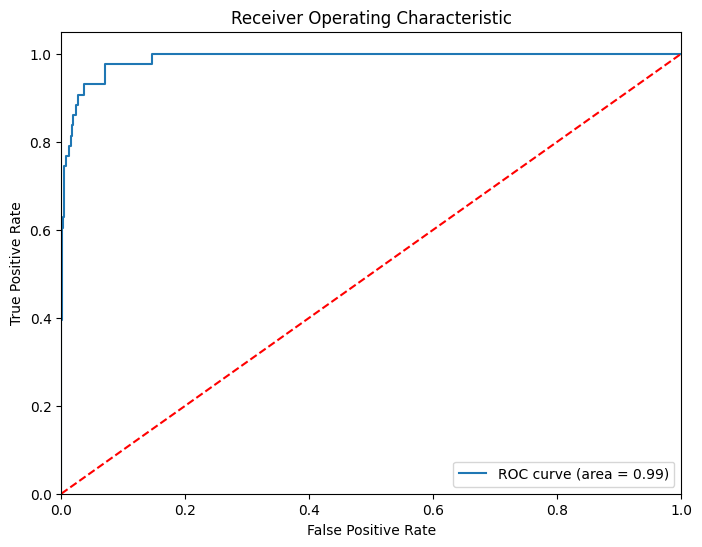

In [30]:
# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_test, y_pred_proba)
